# Sprint 1: Recolección y Preparación de Datos ICFES
## Sistema de Recomendación y Análisis de Rendimiento de Estudiantes

**Proyecto:** Sistema de recomendación basado en resultados ICFES Saber 11  
**Sprint:** 1 - Recolección y Preparación de Datos  
**Nombres:** Jessica Barragan Guzman - Andres Mauricio Serna - German Castellanos

---

### Objetivos del Sprint:
1. Identificar fuentes de datos confiables (APIs, Web Scraping, bases abiertas)
2. Diseñar y probar métodos de extracción de datos
3. Procesar y limpiar datos (valores nulos, duplicados, inconsistencias)
4. Almacenar datos estructurados (CSV, SQL)
5. Crear análisis exploratorio con estadísticas descriptivas

### Entregables:
- Dataset limpio y estructurado
- Código de recolección y limpieza
- Informe de análisis exploratorio

In [9]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import sqlite3
from datetime import datetime
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 2)

print("="*70)
print("SPRINT 1 - SISTEMA DE RECOMENDACIÓN ICFES")
print("Recolección y Preparación de Datos con Fuentes Oficiales")
print("="*70)
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🐍 Versión Python/Pandas: {pd.__version__}")
print("="*70)

SPRINT 1 - SISTEMA DE RECOMENDACIÓN ICFES
Recolección y Preparación de Datos con Fuentes Oficiales
📅 Fecha: 2025-11-03 18:06:36
🐍 Versión Python/Pandas: 2.3.3


## Identificación de Fuentes de Datos Confiables

### Fuentes Oficiales Identificadas:

1. **DataICFES** - https://www.icfes.gov.co/investigaciones/data-icfes/
   - Repositorio oficial con datos históricos desde 1978
   - Formato: .txt (separado por tabuladores), CSV
   - Acceso: Requiere registro en el portal

2. **Datos Abiertos Colombia** - https://www.datos.gov.co
   - Portal nacional de datos abiertos
   - API pública sin autenticación
   - Datasets actualizados por periodo

3. **Kaggle** - https://www.kaggle.com/search?q=ICFES
   - Datasets procesados por la comunidad
   - Diferentes años y formatos

4. **Ministerio de Educación** - https://www.mineducacion.gov.co
   - Reportes estadísticos oficiales
   - Datos complementarios de instituciones

## Diseño e Implementación de Métodos de Extracción

Implementaremos métodos para:
- Descarga desde API de datos.gov.co
- Procesamiento de archivos .txt del DataICFES
- Manejo de errores y logging
- Validación de datos descargados

In [10]:
class DataExtractorICFES:
    """
    Clase para extraer datos reales del ICFES desde diferentes fuentes
    """

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        })
        self.extraction_log = []

    def extract_from_datos_gov(self, dataset_id):
        """
        Extrae datos desde datos.gov.co usando el API de Socrata

        Parámetros:
        -----------
        dataset_id : str
            ID del dataset en datos.gov.co (formato: xxxx-xxxx)
            Ejemplos:
            - 'kgxf-xxbe': Resultados únicos Saber 11
            - 'rnvb-vnyh': Saber 11 2020-2

        Retorna:
        --------
        pd.DataFrame o None
        """
        dataset_id = 'kgxf-xxbe'
        try:
            url = f"https://www.datos.gov.co/api/views/{dataset_id}/rows.csv?accessType=DOWNLOAD"
            print(f"⏳ Descargando dataset {dataset_id} desde datos.gov.co...")
            print(f"   URL: {url}")

            response = self.session.get(url, timeout=120)

            if response.status_code == 200:
                # Intentar diferentes encodings
                for encoding in ['utf-8', 'latin1', 'iso-8859-1']:
                    try:
                        df = pd.read_csv(StringIO(response.text), 
                                       encoding=encoding, 
                                       low_memory=False)
                        break
                    except:
                        continue

                log_entry = {
                    'timestamp': datetime.now(),
                    'source': 'datos.gov.co',
                    'dataset_id': dataset_id,
                    'rows': len(df),
                    'columns': len(df.columns),
                    'status': 'success'
                }
                self.extraction_log.append(log_entry)

                print(f"✅ Dataset descargado exitosamente")
                print(f"   📊 Shape: {df.shape[0]:,} filas x {df.shape[1]} columnas")
                print(f"   💾 Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

                return df
            else:
                print(f"❌ Error HTTP {response.status_code}")
                return None

        except Exception as e:
            print(f"❌ Error en extracción: {str(e)}")
            self.extraction_log.append({
                'timestamp': datetime.now(),
                'source': 'datos.gov.co',
                'dataset_id': dataset_id,
                'status': 'error',
                'error': str(e)
            })
            return None

    def load_dataicfes_txt(self, filepath, separator='\t', encoding='latin1'):
        """
        Carga archivos .txt descargados de DataICFES

        Parámetros:
        -----------
        filepath : str
            Ruta al archivo .txt descargado
        separator : str
            Separador (por defecto tabulador '\t')
        encoding : str
            Codificación del archivo (por defecto 'latin1')
        """
        try:
            print(f"⏳ Cargando archivo local: {filepath}")

            df = pd.read_csv(filepath, 
                           sep=separator, 
                           encoding=encoding, 
                           low_memory=False)

            print(f"✅ Archivo cargado exitosamente")
            print(f"   📊 Shape: {df.shape[0]:,} filas x {df.shape[1]} columnas")

            return df

        except FileNotFoundError:
            print(f"❌ Archivo no encontrado: {filepath}")
            print("   💡 Descarga el archivo desde: https://www.icfes.gov.co/investigaciones/data-icfes/")
            return None
        except Exception as e:
            print(f"❌ Error al cargar archivo: {str(e)}")
            return None

    def get_extraction_log(self):
        """Retorna el log de extracciones"""
        if len(self.extraction_log) > 0:
            return pd.DataFrame(self.extraction_log)
        else:
            return pd.DataFrame()

# Inicializar extractor
extractor = DataExtractorICFES()
print("\n✅ DataExtractorICFES inicializado correctamente\n")


✅ DataExtractorICFES inicializado correctamente



## Descarga de datos desde Datos.gov.co

**Opciones de datasets disponibles:**

1. **kgxf-xxbe** - Resultados únicos Saber 11 (datos agregados)
2. **rnvb-vnyh** - Saber 11 2020-2 (datos por estudiante)
3. Otros datasets disponibles en https://www.datos.gov.co buscando "Saber 11"

**Nota:** Si tienes un archivo .txt descargado de DataICFES, usa la celda alternativa más abajo.

In [13]:
dataset_id = 'kgxf-xxbe'  

print("="*70)
print("DESCARGANDO DATOS REALES DESDE DATOS.GOV.CO")
print("="*70)

df_icfes = extractor.extract_from_datos_gov(dataset_id)

if df_icfes is not None:
    print("\n📋 Primeras columnas del dataset:")
    print(list(df_icfes.columns[:15]))

    print("\n📊 Primeras 3 filas:")
    display(df_icfes.head(3))

    print("\n📈 Información del dataset:")
    df_icfes.info()
else:
    print("\n⚠️ No se pudo descargar el dataset.")
    print("💡 Verifica tu conexión a internet o el ID del dataset.")

DESCARGANDO DATOS REALES DESDE DATOS.GOV.CO
⏳ Descargando dataset kgxf-xxbe desde datos.gov.co...
   URL: https://www.datos.gov.co/api/views/kgxf-xxbe/rows.csv?accessType=DOWNLOAD
✅ Dataset descargado exitosamente
   📊 Shape: 7,109,704 filas x 51 columnas
   💾 Tamaño en memoria: 15474.84 MB

📋 Primeras columnas del dataset:
['PERIODO', 'ESTU_TIPODOCUMENTO', 'ESTU_CONSECUTIVO', 'COLE_AREA_UBICACION', 'COLE_BILINGUE', 'COLE_CALENDARIO', 'COLE_CARACTER', 'COLE_COD_DANE_ESTABLECIMIENTO', 'COLE_COD_DANE_SEDE', 'COLE_COD_DEPTO_UBICACION', 'COLE_COD_MCPIO_UBICACION', 'COLE_CODIGO_ICFES', 'COLE_DEPTO_UBICACION', 'COLE_GENERO', 'COLE_JORNADA']

📊 Primeras 3 filas:


,PERIODO,ESTU_TIPODOCUMENTO,ESTU_CONSECUTIVO,COLE_AREA_UBICACION,COLE_BILINGUE,COLE_CALENDARIO,COLE_CARACTER,COLE_COD_DANE_ESTABLECIMIENTO,COLE_COD_DANE_SEDE,COLE_COD_DEPTO_UBICACION,COLE_COD_MCPIO_UBICACION,COLE_CODIGO_ICFES,COLE_DEPTO_UBICACION,COLE_GENERO,COLE_JORNADA,COLE_MCPIO_UBICACION,COLE_NATURALEZA,COLE_NOMBRE_ESTABLECIMIENTO,COLE_NOMBRE_SEDE,COLE_SEDE_PRINCIPAL,ESTU_COD_DEPTO_PRESENTACION,ESTU_COD_MCPIO_PRESENTACION,ESTU_COD_RESIDE_DEPTO,ESTU_COD_RESIDE_MCPIO,ESTU_DEPTO_PRESENTACION,ESTU_DEPTO_RESIDE,ESTU_ESTADOINVESTIGACION,ESTU_ESTUDIANTE,ESTU_FECHANACIMIENTO,ESTU_GENERO,ESTU_MCPIO_PRESENTACION,ESTU_MCPIO_RESIDE,ESTU_NACIONALIDAD,ESTU_PAIS_RESIDE,ESTU_PRIVADO_LIBERTAD,FAMI_CUARTOSHOGAR,FAMI_EDUCACIONMADRE,FAMI_EDUCACIONPADRE,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,FAMI_TIENEAUTOMOVIL,FAMI_TIENECOMPUTADOR,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,DESEMP_INGLES,PUNT_INGLES,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_LECTURA_CRITICA,PUNT_GLOBAL
0,20131,CR,SB11201310000414,URBANO,N,B,ACADÉMICO,3.12e+11,3.12e+11,11.0,11001.0,22574.0,BOGOTA,FEMENINO,COMPLETA,BOGOTÁ D.C.,NO OFICIAL,GIMN FEMENINO,GIMN FEMENINO,S,11.0,11001.0,11.0,11001.0,BOGOTÁ,BOGOTÁ,PUBLICAR,ESTUDIANTE,08/08/1994,F,BOGOTÁ D.C.,BOGOTÁ D.C.,COLOMBIA,COLOMBIA,N,Cuatro,Educación profesional completa,Educación profesional completa,Estrato 6,Cuatro,Si,Si,Si,Si,B+,94,88,NaN,NaN,NaN,NaN
1,20194,TI,SB11201940464873,RURAL,N,A,TÉCNICO/ACADÉMICO,1.41e+11,2.41e+11,41.0,41016.0,194878.0,HUILA,MIXTO,COMPLETA,AIPE,OFICIAL,INSTITUCION EDUCATIVA JESUS MARIA AGUIRRE CHARRY,DINDAL,N,41.0,41016.0,41.0,41016.0,HUILA,HUILA,PUBLICAR,ESTUDIANTE,15/02/2003,F,AIPE,AIPE,COLOMBIA,COLOMBIA,N,Dos,Postgrado,Primaria completa,Estrato 2,1 a 2,No,Si,Si,Si,B1,71,66,70.0,65.0,69.0,339.0
2,20194,TI,SB11201940464873,RURAL,N,A,TÉCNICO/ACADÉMICO,1.41e+11,2.41e+11,41.0,41016.0,194878.0,HUILA,MIXTO,COMPLETA,AIPE,OFICIAL,INSTITUCION EDUCATIVA JESUS MARIA AGUIRRE CHARRY,DINDAL,N,41.0,41016.0,41.0,41016.0,HUILA,HUILA,PUBLICAR,ESTUDIANTE,15/02/2003,F,AIPE,AIPE,COLOMBIA,COLOMBIA,N,Dos,Postgrado,Primaria completa,Estrato 2,1 a 2,No,Si,Si,Si,B1,71,66,70.0,65.0,69.0,339.0



📈 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109704 entries, 0 to 7109703
Data columns (total 51 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   PERIODO                        int64  
 1   ESTU_TIPODOCUMENTO             object 
 2   ESTU_CONSECUTIVO               object 
 3   COLE_AREA_UBICACION            object 
 4   COLE_BILINGUE                  object 
 5   COLE_CALENDARIO                object 
 6   COLE_CARACTER                  object 
 7   COLE_COD_DANE_ESTABLECIMIENTO  float64
 8   COLE_COD_DANE_SEDE             float64
 9   COLE_COD_DEPTO_UBICACION       float64
 10  COLE_COD_MCPIO_UBICACION       float64
 11  COLE_CODIGO_ICFES              float64
 12  COLE_DEPTO_UBICACION           object 
 13  COLE_GENERO                    object 
 14  COLE_JORNADA                   object 
 15  COLE_MCPIO_UBICACION           object 
 16  COLE_NATURALEZA                object 
 17  COLE_NOMBRE_ESTABL

In [14]:
import os
import pandas as pd
import sqlite3

csv_path = 'datos_icfes_real_limpio.csv'
db_path = 'icfes_data_real.db'

print("="*70)
print("CARGA INTELIGENTE DE DATOS ICFES")
print("="*70)

# OPCIÓN 1: Si existe el CSV limpio, cargarlo (5-10 segundos)
if os.path.exists(csv_path):
    print(f"\n✅ CSV encontrado: {csv_path}")
    print(f"⏳ Cargando...")
    dfclean = pd.read_csv(csv_path, low_memory=False)
    print(f"✅ LISTO: {len(dfclean):,} filas")
    print(f"   ⏱️ Tiempo: ~5-10 segundos")


# OPCIÓN 3: Si no existen, descargar (primera vez solamente)
else:
    print(f"\n⚠️ Archivos no encontrados")


print("\n" + "="*70)


CARGA INTELIGENTE DE DATOS ICFES

✅ CSV encontrado: datos_icfes_real_limpio.csv
⏳ Cargando...
✅ LISTO: 5,722,593 filas
   ⏱️ Tiempo: ~5-10 segundos



## Procesamiento y Limpieza de Datos

Implementaremos las siguientes operaciones:
1. Análisis de valores faltantes
2. Eliminación de duplicados
3. Estandarización de nombres de columnas
4. Validación de tipos de datos
5. Tratamiento de inconsistencias

In [15]:
class DataCleanerICFES:
    """
    Clase para limpiar y procesar datos del ICFES
    """

    def __init__(self):
        self.cleaning_log = []

    def analyze_missing_values(self, df, dataset_name="Dataset"):
        """Analiza valores faltantes en el dataset"""
        print(f"\n{'='*60}")
        print(f"ANÁLISIS DE VALORES FALTANTES: {dataset_name}")
        print('='*60)

        missing_count = df.isnull().sum()
        missing_pct = (missing_count / len(df)) * 100

        missing_df = pd.DataFrame({
            'Columna': missing_count.index,
            'Faltantes': missing_count.values,
            'Porcentaje': missing_pct.values
        })

        missing_df = missing_df[missing_df['Faltantes'] > 0].sort_values('Faltantes', ascending=False)

        if len(missing_df) == 0:
            print("\n✅ No hay valores faltantes en el dataset")
        else:
            print(f"\n⚠️ Se encontraron valores faltantes en {len(missing_df)} columnas:")
            print(missing_df.to_string(index=False))

        self.cleaning_log.append(f"Valores faltantes analizados: {len(missing_df)} columnas afectadas")
        return missing_df

    def remove_duplicates(self, df, subset=None):
        """Elimina filas duplicadas"""
        initial_rows = len(df)
        df_clean = df.drop_duplicates(subset=subset)
        removed_rows = initial_rows - len(df_clean)

        print(f"\n🗑️ Duplicados eliminados: {removed_rows:,}")
        print(f"   Filas originales: {initial_rows:,}")
        print(f"   Filas resultantes: {len(df_clean):,}")

        self.cleaning_log.append(f"Duplicados eliminados: {removed_rows}")
        return df_clean

    def standardize_columns(self, df):
        """Estandariza nombres de columnas"""
        original_cols = df.columns.tolist()

        # Convertir a mayúsculas y reemplazar espacios
        new_cols = []
        for col in df.columns:
            new_col = col.strip().upper().replace(' ', '_').replace('-', '_')
            # Eliminar caracteres especiales
            import re
            new_col = re.sub(r'[^A-Z0-9_]', '', new_col)
            new_cols.append(new_col)

        df.columns = new_cols

        print("\n📝 Columnas estandarizadas:")
        changes = [(old, new) for old, new in zip(original_cols, new_cols) if old != new]
        if len(changes) > 0:
            for old, new in changes[:10]:  # Mostrar primeras 10
                print(f"   {old} → {new}")
            if len(changes) > 10:
                print(f"   ... y {len(changes)-10} más")
        else:
            print("   ✅ Todas las columnas ya están estandarizadas")

        return df

    def validate_data_types(self, df):
        """Valida y muestra tipos de datos"""
        print("\n📊 Tipos de datos por columna:")
        dtype_info = df.dtypes.value_counts()
        print(dtype_info)

        return df

    def get_cleaning_summary(self):
        """Retorna resumen de limpieza"""
        return self.cleaning_log

# Inicializar limpiador
cleaner = DataCleanerICFES()
print("\n✅ DataCleanerICFES inicializado correctamente")


✅ DataCleanerICFES inicializado correctamente


## Aplicación de Limpieza al Dataset

In [ ]:
# Verificar que el dataset fue descargado

if df_icfes is not None:

    print("="*70)
    print("PROCESO DE LIMPIEZA DE DATOS")
    print("="*70)

    # 1. Análisis de calidad inicial
    print(f"\n📊 Dataset original: {df_icfes.shape[0]:,} filas x {df_icfes.shape[1]} columnas")
    print(f"💾 Memoria utilizada: {df_icfes.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # 2. Análisis de valores faltantes
    missing_report = cleaner.analyze_missing_values(df_icfes, "ICFES Saber 11")

    # 3. Eliminar duplicados
    df_clean = cleaner.remove_duplicates(df_icfes)

    # 4. Estandarizar columnas
    df_clean = cleaner.standardize_columns(df_clean)

    # 5. Validar tipos de datos
    df_clean = cleaner.validate_data_types(df_clean)

    print("\n" + "="*70)
    print("✅ LIMPIEZA COMPLETADA")
    print("="*70)

else:
    print("⚠️ Primero debes descargar o cargar un dataset en las celdas anteriores")

PROCESO DE LIMPIEZA DE DATOS

📊 Dataset original: 7,109,704 filas x 51 columnas
💾 Memoria utilizada: 15474.84 MB

ANÁLISIS DE VALORES FALTANTES: ICFES Saber 11

⚠️ Se encontraron valores faltantes en 43 columnas:
                      Columna  Faltantes  Porcentaje
             PUNT_C_NATURALES    2609523    3.67e+01
         PUNT_LECTURA_CRITICA    2609523    3.67e+01
                  PUNT_GLOBAL    2609523    3.67e+01
     PUNT_SOCIALES_CIUDADANAS    2609523    3.67e+01
                COLE_BILINGUE     916870    1.29e+01
         FAMI_ESTRATOVIVIENDA     218219    3.07e+00
          FAMI_EDUCACIONMADRE     212826    2.99e+00
          FAMI_EDUCACIONPADRE     212423    2.99e+00
           FAMI_TIENEINTERNET     191624    2.70e+00
         FAMI_TIENECOMPUTADOR     151217    2.13e+00
          FAMI_TIENEAUTOMOVIL     134769    1.90e+00
            FAMI_CUARTOSHOGAR     128762    1.81e+00
           FAMI_PERSONASHOGAR     128228    1.80e+00
           FAMI_TIENELAVADORA     128086    1

## Almacenamiento de Datos Estructurados

Guardaremos los datos en:
1. **CSV principal limpio**
2. **Tablas normalizadas** (según variables disponibles)
3. **Base de datos SQLite**

In [20]:
csv_path = 'datos_icfes_real_limpio.csv'
db_path = 'icfes_data_real.db'

if os.path.exists(csv_path) and os.path.exists(db_path):
    print("Ya sea ha descargado el dataset")

elif df_clean is not None:

    print("="*70)
    print("ALMACENAMIENTO DE DATOS")
    print("="*70)

    # 1. Guardar dataset principal limpio
    output_file = 'datos_icfes_real_limpio.csv'
    df_clean.to_csv(output_file, index=False, encoding='utf-8')
    print(f"\n✅ Dataset limpio guardado: {output_file}")
    print(f"   Tamaño: {df_clean.shape}")

    # 2. Crear y guardar tablas normalizadas (ajustar según columnas disponibles)
    # Nota: Los nombres de columnas varían según el dataset
    # Adapta estas secciones según las columnas reales de tu dataset

    print("\n📊 Creando tablas normalizadas...")

    # Ejemplo genérico - ajustar según columnas reales
    columnas_disponibles = df_clean.columns.tolist()
    print(f"   Columnas disponibles: {len(columnas_disponibles)}")
    print(f"   Primeras 10: {columnas_disponibles[:10]}")

    # Guardar muestra de las primeras 10 columnas como ejemplo
    if len(df_clean) > 0:
        tabla_muestra = df_clean.iloc[:, :10].copy()
        tabla_muestra.to_csv('tabla_muestra.csv', index=False)
        print(f"\n✅ Tabla de muestra guardada: tabla_muestra.csv")

    # 3. Almacenar en SQLite
    print("\n💾 Creando base de datos SQLite...")
    conn = sqlite3.connect('icfes_data_real.db')

    df_clean.to_sql('datos_completos', conn, if_exists='replace', index=False)
    print(f"✅ Tabla 'datos_completos' creada en icfes_data_real.db")

    conn.close()

    print("\n" + "="*70)
    print("✅ ALMACENAMIENTO COMPLETADO")
    print("="*70)

else:
    print("⚠️ No hay datos limpios para almacenar")

Ya sea ha descargado el dataset


## Análisis Exploratorio de Datos (EDA)

Realizaremos:
1. Estadísticas descriptivas generales
2. Análisis de variables numéricas
3. Análisis de variables categóricas
4. Visualizaciones clave
5. Correlaciones (si aplica)

In [15]:
if df_clean is not None:

    print("="*70)
    print("ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
    print("="*70)

    # 1. Información general
    print("\n📊 INFORMACIÓN GENERAL DEL DATASET")
    print("-" * 70)
    print(f"Filas: {df_clean.shape[0]:,}")
    print(f"Columnas: {df_clean.shape[1]}")
    print(f"Memoria: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # 2. Tipos de datos
    print("\n📋 DISTRIBUCIÓN DE TIPOS DE DATOS")
    print("-" * 70)
    print(df_clean.dtypes.value_counts())

    # 3. Variables numéricas
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\n🔢 VARIABLES NUMÉRICAS ({len(numeric_cols)})")
    print("-" * 70)

    if len(numeric_cols) > 0:
        print("Estadísticas descriptivas:")
        display(df_clean[numeric_cols].describe())
    else:
        print("No se encontraron variables numéricas")

    # 4. Variables categóricas
    categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
    print(f"\n📝 VARIABLES CATEGÓRICAS ({len(categorical_cols)})")
    print("-" * 70)

    if len(categorical_cols) > 0:
        for col in categorical_cols[:10]:  # Mostrar primeras 10
            unique_count = df_clean[col].nunique()
            print(f"{col}: {unique_count} valores únicos")

else:
    print("⚠️ No hay datos para analizar")

ANÁLISIS EXPLORATORIO DE DATOS (EDA)

📊 INFORMACIÓN GENERAL DEL DATASET
----------------------------------------------------------------------
Filas: 5,722,593
Columnas: 51
Memoria: 12815.50 MB

📋 DISTRIBUCIÓN DE TIPOS DE DATOS
----------------------------------------------------------------------
object     37
float64    13
int64       1
Name: count, dtype: int64

🔢 VARIABLES NUMÉRICAS (14)
----------------------------------------------------------------------
Estadísticas descriptivas:


,PERIODO,COLE_COD_DANE_ESTABLECIMIENTO,COLE_COD_DANE_SEDE,COLE_COD_DEPTO_UBICACION,COLE_COD_MCPIO_UBICACION,COLE_CODIGO_ICFES,ESTU_COD_DEPTO_PRESENTACION,ESTU_COD_MCPIO_PRESENTACION,ESTU_COD_RESIDE_DEPTO,ESTU_COD_RESIDE_MCPIO,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_LECTURA_CRITICA,PUNT_GLOBAL
count,5.72e+06,5.72e+06,5.72e+06,5.72e+06,5.72e+06,5.70e+06,5.72e+06,5.72e+06,5.69e+06,5.69e+06,3.40e+06,3.40e+06,3.40e+06,3.40e+06
mean,2.02e+04,2.10e+11,2.10e+11,3.29e+01,3.31e+04,1.18e+05,3.28e+01,3.30e+04,3.54e+01,3.31e+04,4.94e+01,5.05e+01,5.20e+01,2.53e+02
std,3.59e+01,9.57e+10,9.78e+10,2.68e+01,2.68e+04,1.57e+05,2.68e+01,2.68e+04,5.04e+02,2.68e+04,1.15e+01,1.05e+01,1.03e+01,4.98e+01
min,2.01e+04,1.05e+10,0.00e+00,5.00e+00,5.00e+03,0.00e+00,5.00e+00,5.00e+03,5.00e+00,5.00e+03,0.00e+00,0.00e+00,0.00e+00,0.00e+00
25%,2.01e+04,1.18e+11,1.18e+11,1.10e+01,1.10e+04,3.12e+04,1.10e+01,1.10e+04,1.10e+01,1.10e+04,4.10e+01,4.30e+01,4.50e+01,2.16e+02
50%,2.01e+04,1.76e+11,1.76e+11,2.00e+01,2.02e+04,8.50e+04,2.00e+01,2.00e+04,2.00e+01,2.02e+04,4.90e+01,5.00e+01,5.20e+01,2.50e+02
75%,2.02e+04,3.11e+11,3.11e+11,5.40e+01,5.45e+04,1.32e+05,5.40e+01,5.45e+04,5.40e+01,5.45e+04,5.80e+01,5.80e+01,5.90e+01,2.87e+02
max,2.02e+04,6.26e+11,8.55e+11,9.90e+01,9.98e+04,8.07e+05,9.90e+01,9.98e+04,1.00e+05,1.00e+05,1.00e+02,1.00e+02,1.00e+02,4.95e+02



📝 VARIABLES CATEGÓRICAS (37)
----------------------------------------------------------------------
ESTU_TIPODOCUMENTO: 19 valores únicos
ESTU_CONSECUTIVO: 5720733 valores únicos
COLE_AREA_UBICACION: 2 valores únicos
COLE_BILINGUE: 2 valores únicos
COLE_CALENDARIO: 3 valores únicos
COLE_CARACTER: 4 valores únicos
COLE_DEPTO_UBICACION: 34 valores únicos
COLE_GENERO: 3 valores únicos
COLE_JORNADA: 6 valores únicos
COLE_MCPIO_UBICACION: 1411 valores únicos



📊 VISUALIZACIONES


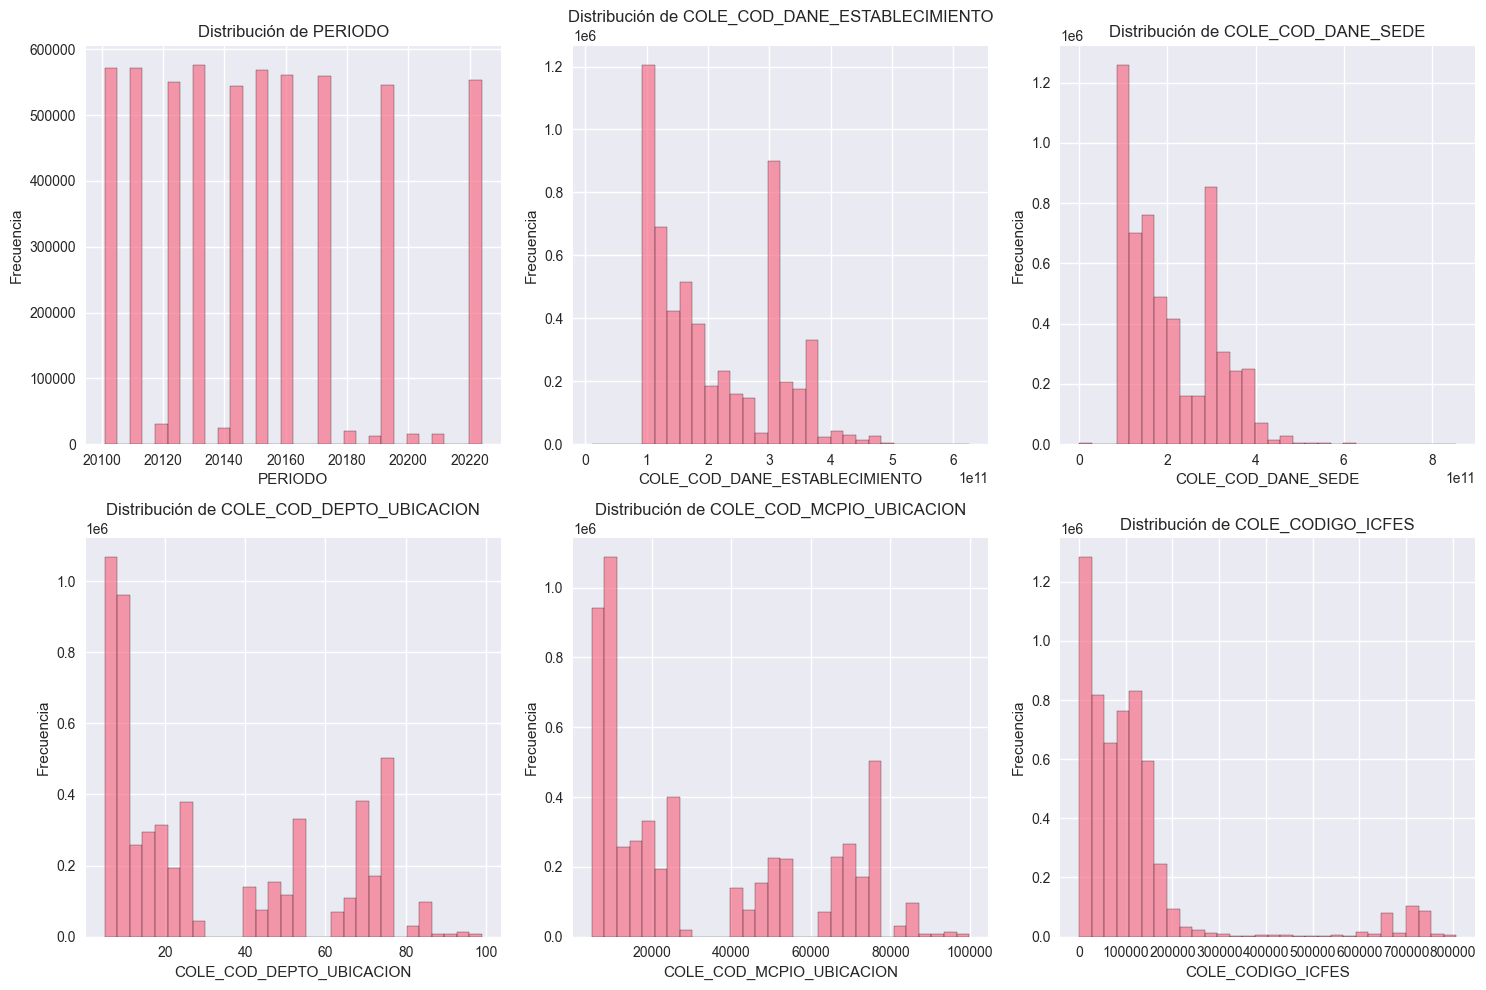


✅ Histogramas generados

📊 Matriz de Correlación


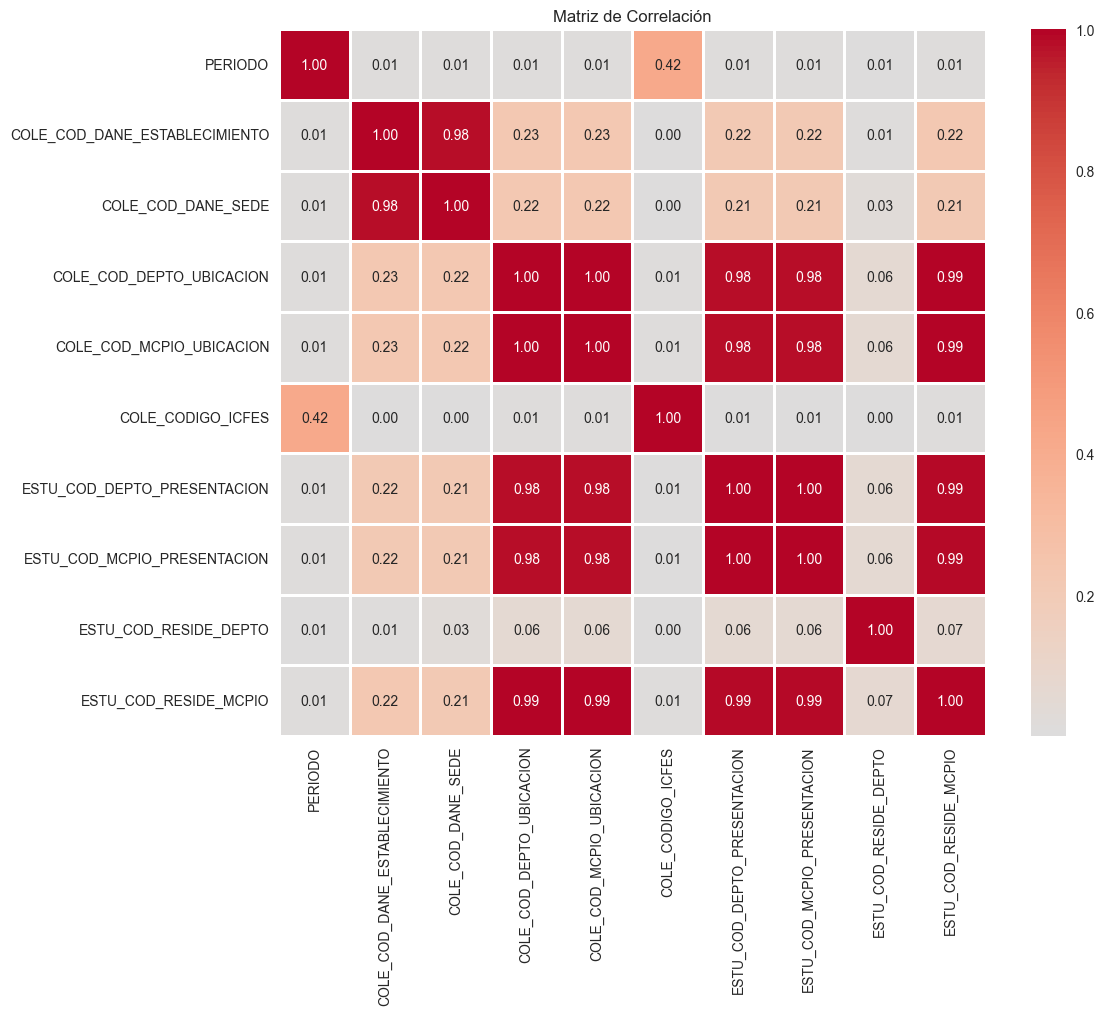


✅ Matriz de correlación generada


In [16]:
if df_clean is not None and len(numeric_cols) > 0:

    print("\n📊 VISUALIZACIONES")
    print("="*70)

    # Seleccionar primeras variables numéricas para visualizar
    cols_to_plot = numeric_cols[:6]  # Máximo 6 para no saturar

    if len(cols_to_plot) > 0:
        # Histogramas
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for i, col in enumerate(cols_to_plot):
            if i < len(axes):
                df_clean[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
                axes[i].set_title(f'Distribución de {col}')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Frecuencia')

        # Ocultar ejes vacíos
        for i in range(len(cols_to_plot), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()

        print("\n✅ Histogramas generados")

    # Matriz de correlación (si hay suficientes variables numéricas)
    if len(numeric_cols) >= 2:
        print("\n📊 Matriz de Correlación")

        # Tomar máximo 10 variables para correlación
        corr_cols = numeric_cols[:10]
        correlation_matrix = df_clean[corr_cols].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, square=True, linewidths=1)
        plt.title('Matriz de Correlación')
        plt.tight_layout()
        plt.show()

        print("\n✅ Matriz de correlación generada")

else:
    print("⚠️ No hay suficientes variables numéricas para visualizaciones")

In [27]:
dfclean = pd.read_csv('datos_icfes_real_limpio.csv', low_memory=False)

print("PERIODO únicos:", dfclean['PERIODO'].unique()[:20])
print("COLE_DEPTO_UBICACION únicos:", dfclean['COLE_DEPTO_UBICACION'].unique()[:10])
print("PUNT_GLOBAL rango:", dfclean['PUNT_GLOBAL'].min(), "-", dfclean['PUNT_GLOBAL'].max())


PERIODO únicos: [20131 20194 20122 20132 20162 20172 20102 20142 20111 20112 20152 20121
 20171 20151 20101 20201 20161 20191 20224 20211]
COLE_DEPTO_UBICACION únicos: ['BOGOTA' 'HUILA' 'QUINDIO' 'CAUCA' 'VALLE' 'TOLIMA' 'ANTIOQUIA'
 'PUTUMAYO' 'SANTANDER' 'ATLANTICO']
PUNT_GLOBAL rango: 0.0 - 495.0


In [31]:
import os

csv_filtrado = 'datos_icfes_filtrado.csv'

# Si el CSV filtrado existe, cargarlo (2 segundos)
if os.path.exists(csv_filtrado):
    dfclean = pd.read_csv(csv_filtrado, low_memory=False)
    print(f"✅ Cargado filtrado: {len(dfclean):,} filas")
else:
    # Si no existe, cargar CSV original, filtrar y guardar
    dfclean = pd.read_csv('datos_icfes_real_limpio.csv', low_memory=False)
    
    print(f"Dataset original: {len(dfclean):,} filas")
    
    # Aplicar filtro CORRECTO
    dfclean = dfclean[
        (dfclean['PERIODO'] >= 20191) &  # Correcto: 20211 no 202101
        (dfclean['COLE_DEPTO_UBICACION'].isin(['TOLIMA'])) &
        (dfclean['PUNT_GLOBAL'] > 0)  # Excluir 0s
    ]
    
    print(f"Después de filtrar: {len(dfclean):,} filas")
    
    # Guardar filtrado
    dfclean.to_csv(csv_filtrado, index=False)
    print(f"✅ Guardado: {csv_filtrado}")


Dataset original: 1,509,724 filas
Después de filtrar: 5,066 filas
✅ Guardado: datos_icfes_filtrado.csv


# SPRINT 2 - Clusterización, Series Temporales y Predicción


In [32]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("✅ Librerías Sprint 2 importadas correctamente")


✅ Librerías Sprint 2 importadas correctamente


In [50]:
print("\n" + "="*70)
print("SPRINT 2 - ANÁLISIS DE CLUSTERIZACIÓN")
print("="*70)

# Preparar datos
numeric_cols = dfclean.select_dtypes(include=[np.number]).columns.tolist()
X_cluster_full = dfclean[numeric_cols].dropna()

print(f"\n✅ Dataset original: {X_cluster_full.shape}")

# SAMPLEAR para velocidad
sample_size = 1000
X_cluster = X_cluster_full.sample(n=min(sample_size, len(X_cluster_full)), random_state=42)

print(f"✅ Dataset para clusterización (muestra): {X_cluster.shape}")

# Normalizar
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_cluster)
print(f"   Datos normalizados: {X_scaled.shape}")



SPRINT 2 - ANÁLISIS DE CLUSTERIZACIÓN

✅ Dataset original: (5047, 14)
✅ Dataset para clusterización (muestra): (1000, 14)
   Datos normalizados: (1000, 14)



⏳ Buscando k óptimo...
   ✓ k=2 completado
   ✓ k=3 completado
   ✓ k=4 completado
   ✓ k=5 completado
   ✓ k=6 completado
✅ Búsqueda de k completada


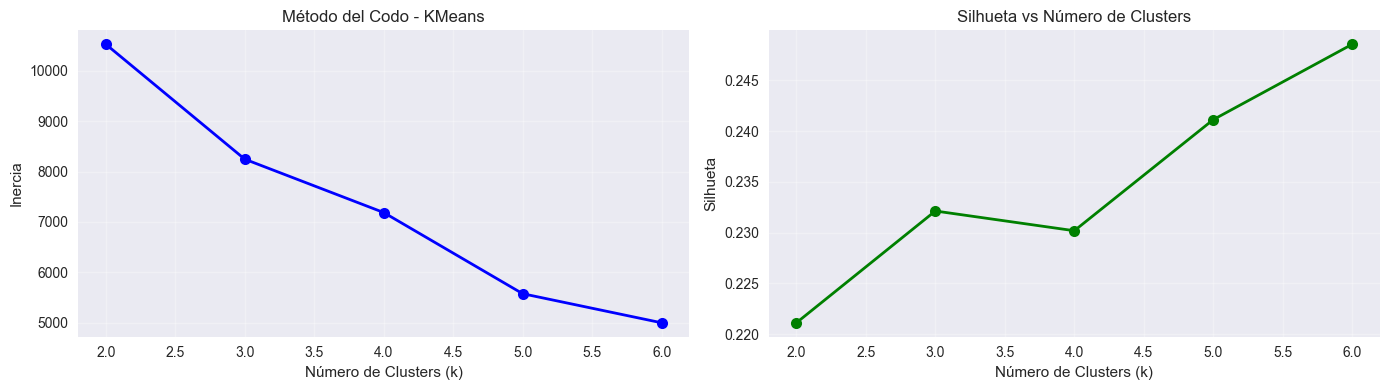


✅ K óptimo: 6
⏳ Entrenando KMeans final...
✅ KMeans entrenado

📊 MÉTRICAS KMeans (k=6):
   Silhueta: 0.2485
   Davies-Bouldin: 1.0605
   Calinski-Harabasz: 317.8709


In [53]:
print(f"\n⏳ Buscando k óptimo...")
inertias = []
silhouettes = []
K_range = range(2, 7)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=100)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans_temp.labels_))
    print(f"   ✓ k={k} completado")
print("✅ Búsqueda de k completada")

# Corrección aquí:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Método del Codo - KMeans')
axes[0].grid(True, alpha=0.3)
axes[1].plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Silhueta')
axes[1].set_title('Silhueta vs Número de Clusters')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

k_optimal = list(K_range)[np.argmax(silhouettes)]
print(f"\n✅ K óptimo: {k_optimal}")

print(f"⏳ Entrenando KMeans final...")
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=5, max_iter=100)
kmeans_labels = kmeans.fit_predict(X_scaled)
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
db_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)
ch_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
print(f"✅ KMeans entrenado")
print(f"\n📊 MÉTRICAS KMeans (k={k_optimal}):")
print(f"   Silhueta: {sil_kmeans:.4f}")
print(f"   Davies-Bouldin: {db_kmeans:.4f}")
print(f"   Calinski-Harabasz: {ch_kmeans:.4f}")



⏳ Calculando K-distance graph...


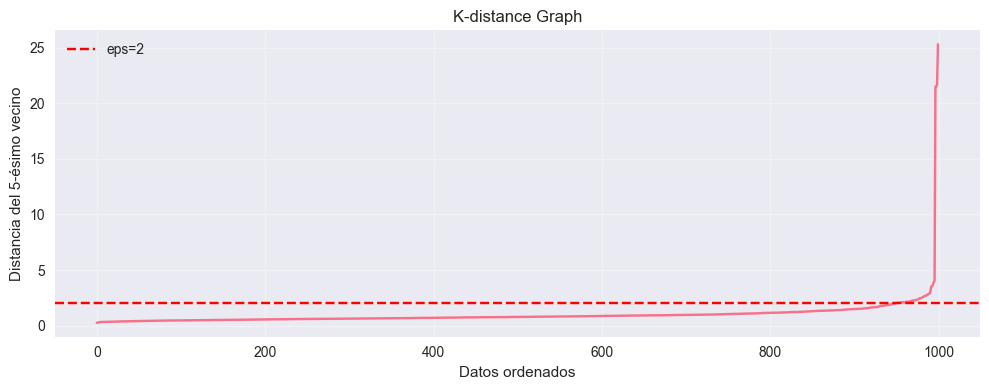


✅ DBSCAN (eps=2.0, min_samples=5)
   Clusters: 4
   Puntos de ruido: 35
   Silhueta: 0.3560
   Davies-Bouldin: 0.9336


In [54]:
print(f"\n⏳ Calculando K-distance graph...")
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1], axis=0)
plt.figure(figsize=(10, 4))
plt.plot(distances)
plt.xlabel('Datos ordenados')
plt.ylabel('Distancia del 5-ésimo vecino')
plt.title('K-distance Graph')
plt.axhline(y=2, color='r', linestyle='--', label='eps=2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

eps_val = 2.0
dbscan = DBSCAN(eps=eps_val, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clust_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"\n✅ DBSCAN (eps={eps_val}, min_samples=5)")
print(f"   Clusters: {n_clust_db}")
print(f"   Puntos de ruido: {n_noise}")
mask_db = dbscan_labels != -1
if len(set(dbscan_labels[mask_db])) > 1:
    sil_db = silhouette_score(X_scaled[mask_db], dbscan_labels[mask_db])
    db_db = davies_bouldin_score(X_scaled[mask_db], dbscan_labels[mask_db])
    print(f"   Silhueta: {sil_db:.4f}")
    print(f"   Davies-Bouldin: {db_db:.4f}")



⏳ Calculando clustering jerárquico...


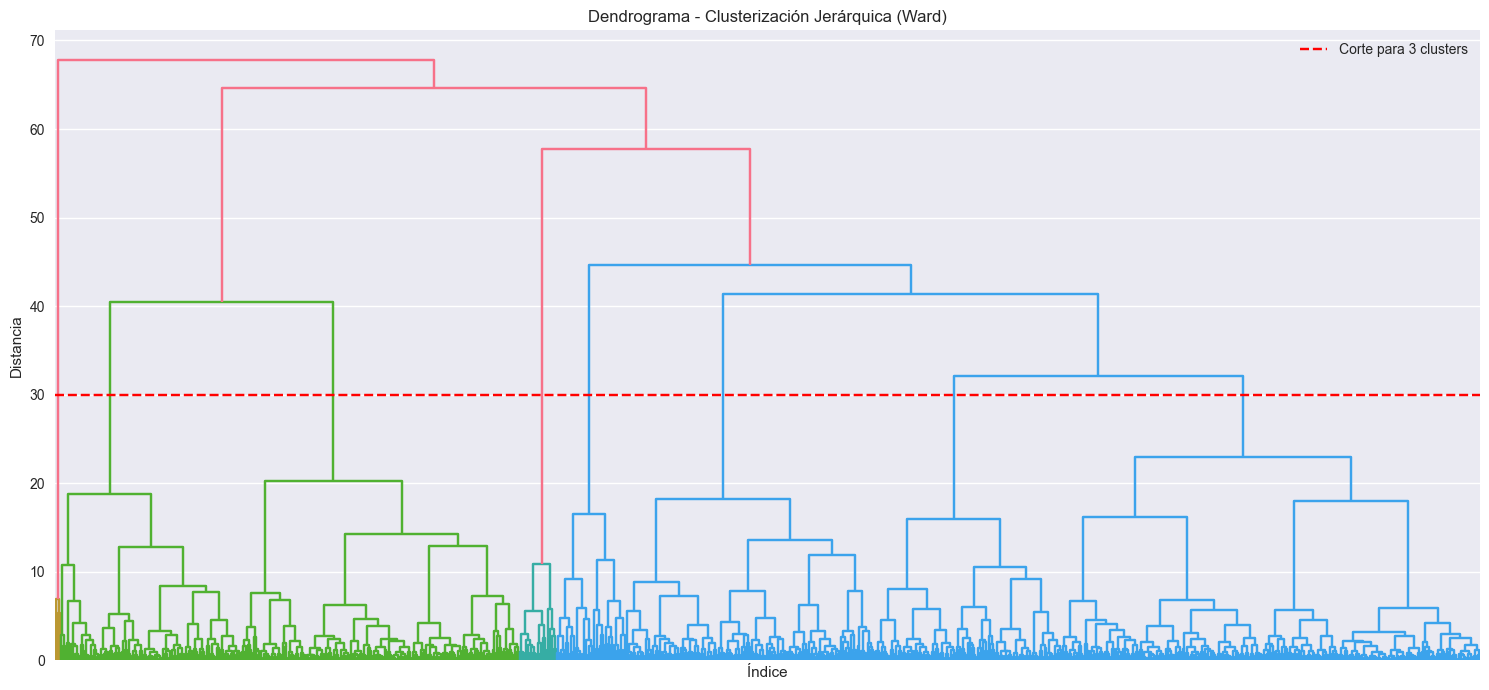


✅ Clusterización Jerárquica (k=3)
   Silhueta: 0.2051
   Davies-Bouldin: 1.1958

📊 Visualizando clusters en 2D...


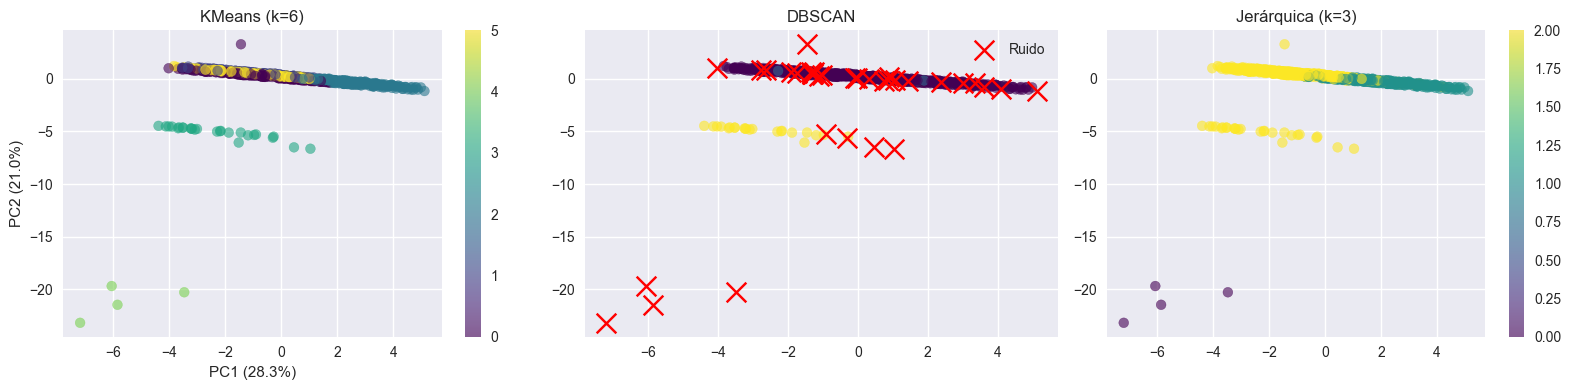

✅ Visualización completada


In [55]:
print(f"\n⏳ Calculando clustering jerárquico...")
Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(15, 7))
dendrogram(Z, no_labels=True)
plt.title('Dendrograma - Clusterización Jerárquica (Ward)')
plt.xlabel('Índice')
plt.ylabel('Distancia')
plt.axhline(y=30, color='r', linestyle='--', label='Corte para 3 clusters')
plt.legend()
plt.tight_layout()
plt.show()

n_clust_hier = 3
hier_labels = fcluster(Z, n_clust_hier, criterion='maxclust') - 1
sil_hier = silhouette_score(X_scaled, hier_labels)
db_hier = davies_bouldin_score(X_scaled, hier_labels)
print(f"\n✅ Clusterización Jerárquica (k={n_clust_hier})")
print(f"   Silhueta: {sil_hier:.4f}")
print(f"   Davies-Bouldin: {db_hier:.4f}")

print(f"\n📊 Visualizando clusters en 2D...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
s1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6)
axes[0].set_title(f'KMeans (k={k_optimal})')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(s1, ax=axes[0])
mask_vis = dbscan_labels != -1
s2 = axes[1].scatter(X_pca[mask_vis, 0], X_pca[mask_vis, 1], c=dbscan_labels[mask_vis], cmap='viridis', s=50, alpha=0.6)
axes[1].scatter(X_pca[~mask_vis, 0], X_pca[~mask_vis, 1], c='red', marker='x', s=200, label='Ruido')
axes[1].set_title(f'DBSCAN')
axes[1].legend()
s3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=hier_labels, cmap='viridis', s=50, alpha=0.6)
axes[2].set_title(f'Jerárquica (k={n_clust_hier})')
plt.colorbar(s3, ax=axes[2])
plt.tight_layout()
plt.show()
print("✅ Visualización completada")



SPRINT 2 - ANÁLISIS DE SERIES TEMPORALES

✅ Serie temporal real: 4 períodos


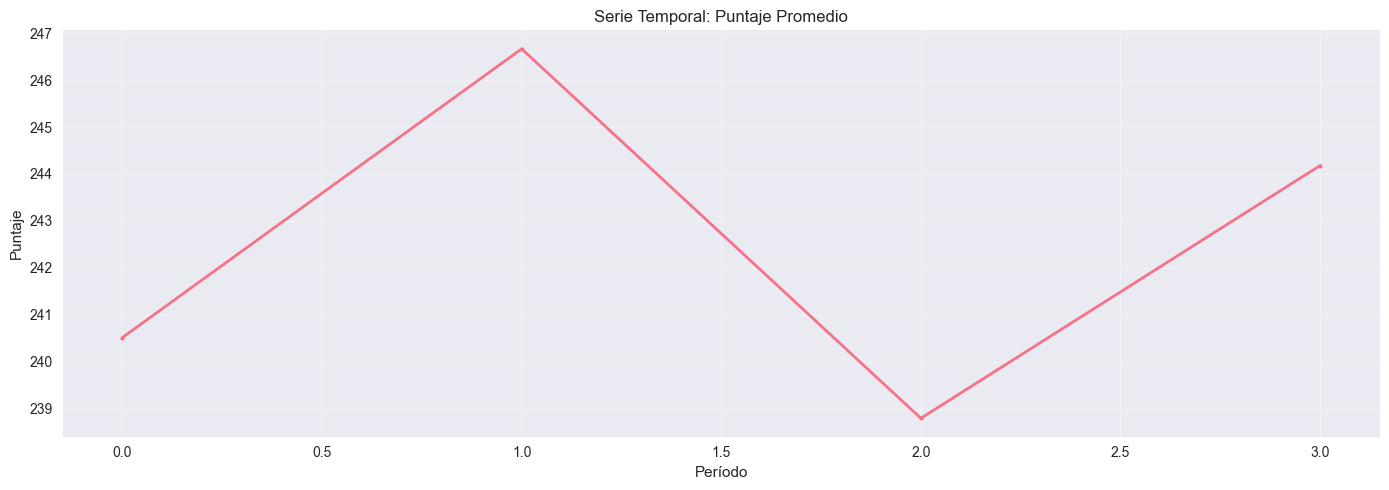


📊 PRUEBA ADF DE ESTACIONARIEDAD:
   P-valor: 0.003006
   Estacionaria: Sí


In [56]:
print("\n" + "="*70)
print("SPRINT 2 - ANÁLISIS DE SERIES TEMPORALES")
print("="*70)
if 'PUNT_GLOBAL' in dfclean.columns:
    try:
        ts_data = dfclean.groupby('PERIODO')['PUNT_GLOBAL'].mean()
        ts_values = ts_data.values
        print(f"\n✅ Serie temporal real: {len(ts_values)} períodos")
    except:
        ts_values = dfclean['PUNT_GLOBAL'].dropna().values
        print(f"\n✅ Serie temporal: {len(ts_values)} registros")
else:
    print(f"⚠️ PUNT_GLOBAL no encontrado")
    ts_values = None

if ts_values is not None and len(ts_values) > 1:
    plt.figure(figsize=(14, 5))
    plt.plot(ts_values, linewidth=2, marker='o', markersize=3)
    plt.title('Serie Temporal: Puntaje Promedio')
    plt.xlabel('Período')
    plt.ylabel('Puntaje')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    adf = adfuller(ts_values)
    print(f"\n📊 PRUEBA ADF DE ESTACIONARIEDAD:")
    print(f"   P-valor: {adf[1]:.6f}")
    print(f"   Estacionaria: {'Sí' if adf[1] < 0.05 else 'No'}")


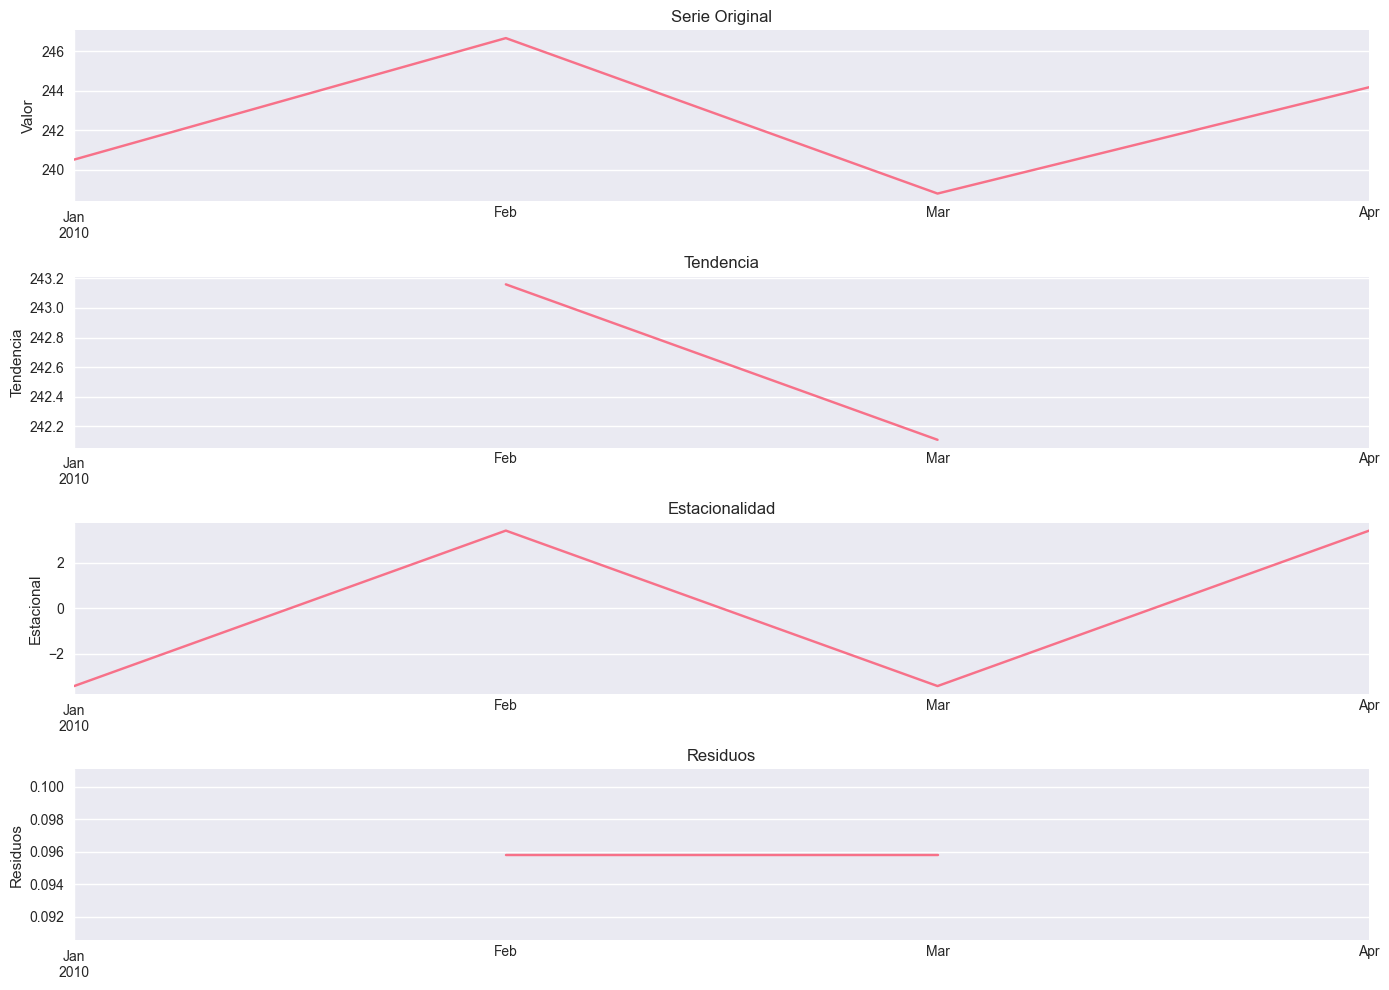

✅ Descomposición completada


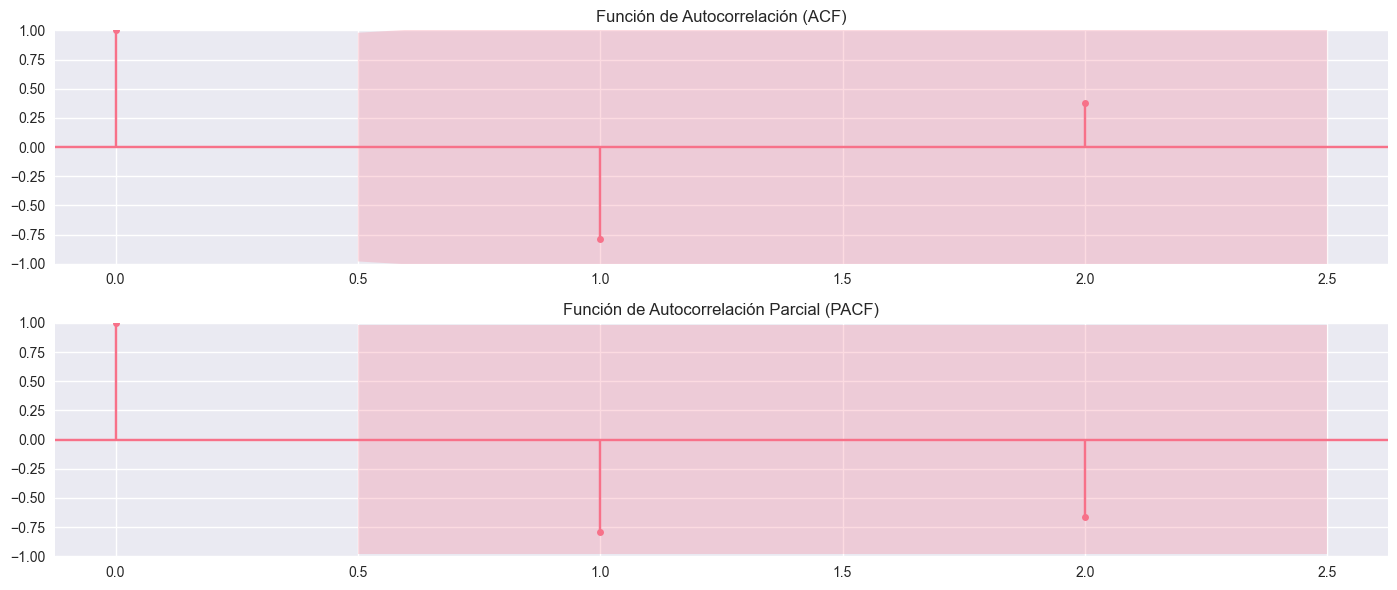

✅ Análisis ACF/PACF completado


In [57]:
if ts_values is not None and len(ts_values) > 1:
    ts_series = pd.Series(ts_values, 
                          index=pd.date_range('2010-01', periods=len(ts_values), freq='M'))
    try:
        decomp = seasonal_decompose(ts_series, model='additive', period=min(12, len(ts_values)//2))
        fig, axes = plt.subplots(4, 1, figsize=(14, 10))
        ts_series.plot(ax=axes[0], title='Serie Original')
        axes[0].set_ylabel('Valor')
        decomp.trend.plot(ax=axes[1], title='Tendencia')
        axes[1].set_ylabel('Tendencia')
        decomp.seasonal.plot(ax=axes[2], title='Estacionalidad')
        axes[2].set_ylabel('Estacional')
        decomp.resid.plot(ax=axes[3], title='Residuos')
        axes[3].set_ylabel('Residuos')
        plt.tight_layout()
        plt.show()
        print("✅ Descomposición completada")
    except Exception as e:
        print(f"⚠️ No se pudo descomponer: {e}")
    try:
        fig, axes = plt.subplots(2, 1, figsize=(14, 6))
        plot_acf(ts_values, lags=min(20, len(ts_values)//2), ax=axes[0])
        axes[0].set_title('Función de Autocorrelación (ACF)')
        plot_pacf(ts_values, lags=min(20, len(ts_values)//2), ax=axes[1])
        axes[1].set_title('Función de Autocorrelación Parcial (PACF)')
        plt.tight_layout()
        plt.show()
        print("✅ Análisis ACF/PACF completado")
    except Exception as e:
        print(f"⚠️ No se pudo calcular ACF/PACF: {e}")


In [64]:
print(f"Longitud ts_values: {len(ts_values) if ts_values is not None else 0}")
print("Primeros 10:", ts_values[:10] if ts_values is not None and len(ts_values) >= 10 else ts_values)


Longitud ts_values: 4
Primeros 10: [240.5134403  246.66666667 238.79310345 244.1797235 ]


In [58]:
if ts_values is not None and len(ts_values) > 5:
    print("\n" + "="*70)
    print("SPRINT 2 - MODELOS PREDICTIVOS")
    print("="*70)
    if isinstance(ts_values, pd.Series):
        ts_array = ts_values.values
    else:
        ts_array = np.asarray(ts_values).flatten()
    print(f"\n✅ Serie temporal: {len(ts_array)} valores")
    train_size = max(int(len(ts_array) * 0.8), len(ts_array) - 5)
    train_ts = ts_array[:train_size]
    test_ts = ts_array[train_size:]
    print(f"✅ Datos divididos:")
    print(f"   Entrenamiento: {len(train_ts)}")
    print(f"   Prueba: {len(test_ts)}")
    try:
        print("\n⏳ Entrenando ARIMA...")
        model = ARIMA(train_ts, order=(1,1,1))
        fitted = model.fit()
        forecast_result = fitted.get_forecast(steps=len(test_ts))
        pred_arima = np.asarray(forecast_result.predicted_mean).flatten()
        mse_a = mean_squared_error(test_ts, pred_arima)
        rmse_a = np.sqrt(mse_a)
        mae_a = mean_absolute_error(test_ts, pred_arima)
        print(f"✅ ARIMA(1,1,1) entrenado")
        print(f"   RMSE: {rmse_a:.6f}")
        print(f"   MAE: {mae_a:.6f}")
        arima_ok = True
        plt.figure(figsize=(14, 5))
        plt.plot(train_ts, label='Entrenamiento', linewidth=2)
        plt.plot(range(train_size, len(ts_array)), test_ts, label='Prueba Real', linewidth=2)
        plt.plot(range(train_size, len(ts_array)), pred_arima, label='Predicción ARIMA', linestyle='--', linewidth=2)
        plt.xlabel('Período')
        plt.ylabel('Puntaje')
        plt.title('Predicciones ARIMA')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Error ARIMA: {e}")
        arima_ok = False
else:
    print("⚠️ Datos insuficientes para modelos predictivos")


⚠️ Datos insuficientes para modelos predictivos


In [63]:
if ts_values is not None and len(ts_values) > 20:
    def crear_secuencias(data, lookback=12):
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data[i:i+lookback])
            y.append(data[i+lookback])
        return np.array(X), np.array(y)

    # Normalizar
    scaler_ts = MinMaxScaler()
    scaled = scaler_ts.fit_transform(ts_array.reshape(-1,1))

    # Secuencias
    lookback = min(12, max(3, len(scaled)//10))
    X_seq, y_seq = crear_secuencias(scaled, lookback)

    if len(X_seq) > 10:
        split = int(len(X_seq) * 0.8)
        X_tr, X_te = X_seq[:split], X_seq[split:]
        y_tr, y_te = y_seq[:split], y_seq[split:]
        
        try:
            print(f"\n⏳ Entrenando LSTM (lookback={lookback})...")
            model_lstm = Sequential([
                LSTM(50, activation='relu', input_shape=(lookback, 1)),
                Dropout(0.2),
                Dense(25, activation='relu'),
                Dense(1)
            ])
            
            model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
            
            hist = model_lstm.fit(X_tr, y_tr, epochs=20, batch_size=16, 
                                  validation_split=0.2, verbose=0)
            
            print("✅ LSTM entrenado")
            
            pred_lstm = model_lstm.predict(X_te, verbose=0)
            y_te_orig = scaler_ts.inverse_transform(y_te.reshape(-1,1))
            pred_lstm_orig = scaler_ts.inverse_transform(pred_lstm)
            
            mse_l = mean_squared_error(y_te_orig, pred_lstm_orig)
            rmse_l = np.sqrt(mse_l)
            mae_l = mean_absolute_error(y_te_orig, pred_lstm_orig)
            
            print(f"   RMSE: {rmse_l:.6f}")
            print(f"   MAE: {mae_l:.6f}")
            
            lstm_ok = True
            
            # Histórico
            plt.figure(figsize=(12, 4))
            plt.plot(hist.history['loss'], label='Entrenamiento')
            plt.plot(hist.history['val_loss'], label='Validación')
            plt.xlabel('Época')
            plt.ylabel('Pérdida')
            plt.title('Histórico LSTM')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"⚠️ Error LSTM: {e}")
            lstm_ok = False
    else:
        print("⚠️ Datos insuficientes para LSTM")
        lstm_ok = False


In [62]:
if ts_values is not None and len(ts_values) > 20 and len(X_seq) > 10:
    try:
        print(f"\n⏳ Entrenando GRU...")
        model_gru = Sequential([
            GRU(50, activation='relu', input_shape=(lookback, 1)),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        
        model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        model_gru.fit(X_tr, y_tr, epochs=20, batch_size=16, 
                      validation_split=0.2, verbose=0)
        
        print("✅ GRU entrenado")
        
        pred_gru = model_gru.predict(X_te, verbose=0)
        pred_gru_orig = scaler_ts.inverse_transform(pred_gru)
        
        mse_g = mean_squared_error(y_te_orig, pred_gru_orig)
        rmse_g = np.sqrt(mse_g)
        mae_g = mean_absolute_error(y_te_orig, pred_gru_orig)
        
        print(f"   RMSE: {rmse_g:.6f}")
        print(f"   MAE: {mae_g:.6f}")
        
        gru_ok = True
        
    except Exception as e:
        print(f"⚠️ Error GRU: {e}")
        gru_ok = False

    # Comparación final
    print(f"\n📊 COMPARACIÓN DE MODELOS:")
    print(f"{'Modelo':<15} {'RMSE':<15} {'MAE':<15}")
    print("-" * 45)

    if arima_ok:
        print(f"{'ARIMA':<15} {rmse_a:<15.6f} {mae_a:<15.6f}")
    if lstm_ok:
        print(f"{'LSTM':<15} {rmse_l:<15.6f} {mae_l:<15.6f}")
    if gru_ok:
        print(f"{'GRU':<15} {rmse_g:<15.6f} {mae_g:<15.6f}")

    print("\n" + "="*70)
    print("✅ SPRINT 2 COMPLETADO EXITOSAMENTE")
    print("="*70)
